# liveplot: The Resurrection

This notebook demonstrates the usage for the `liveplot` module, which effectively consists of a single function: `liveplot.create_plot`.

In [1]:
import numpy as np

try:
    # `liveplot` works with jupyter themes plot styles!
    from jupyterthemes import jtplot
    jtplot.style()
except ImportError:
    pass

from liveplot import create_plot
%matplotlib notebook

## Demonstrating live plotting
Suppose we want to log and plot two metrics, accuracy and loss, as they are being calculated during train/test time. We specify these metric's names to `create_plot`. Here, we also specify the color that we want the metrics to be plotted in. This is optional. We specify that we want our plotter to refresh the figure each time a plot call is made, by setting`refresh=0`. 

**Plotting is a blocking process**

It is advisable to set `refresh` to a more sensible value, like `1.` (refresh at most once every 1 second), so that plotting does not become a bottleneck.

<IPython.core.display.Javascript object>


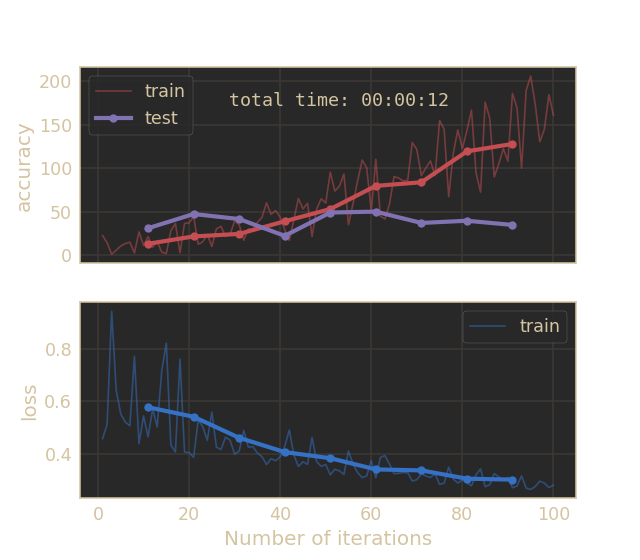

In [2]:
# metric -> color. 
# train-accuracy: use color-2 in default color cycle
# test-accuracy: use color-$ in default color cycle
# loss : use default color
metrics = {"accuracy":dict(train="C2", test="C3"), 
           "loss": None}
# List of metric-names is also valid
                           
# `fig`, `ax` are the familiar objects returned by `matplotlib.pyplot.subplots()`
# `plotter` is used to set all of the train/test batch data, and to control when
# plotting occurs
plotter, fig, ax = create_plot(metrics, refresh=0)

# this figure is blank, but will update as the data is logged to `plotter`

In the following, we set the batch-level training metrics using `plotter.set_train_batch`. This will automatically trigger plotting (still heeding the refresh rate). You can also set `plot=False`, if you do not want to plot batch-level information.

`plotter.set_test_batch` similarly sets batch level test-time metrics, but never plots. You don't need to have the same test and train metrics. E.g. you may have loss and accuracy for training, but only accuracy for testing.

We must specify what the batch-size is, so that batch-averaged statistics can be weighted appropriately when plotting epoch-level information.

Lastly, we use `plotter.plot_train_epoch` and `plotter.plot_test_epoch` to cue the epoch metrics to be computed and plotted.

In [3]:
for i, x in enumerate(np.linspace(0, 10, 100)):
    # training
    x += np.random.rand(1)*5
    batch_metrics = {"accuracy": x**2, "loss": 1/x**.5}
    plotter.set_train_batch(batch_metrics, batch_size=1, plot=True)
    
    # cue training epoch
    if i%10 == 0 and i > 0:
        plotter.plot_train_epoch()
        
        # cue test-time computations
        for x in np.linspace(0, 10, 5):
            x += (np.random.rand(1) - 0.5)*5
            test_metrics = {"accuracy": x**2}
            plotter.set_test_batch(test_metrics, batch_size=1)
        plotter.plot_test_epoch()

plotter.plot()  # ensures final data gets plotted

`plotter` has a nice repr to summarize stuff:

In [4]:
plotter

LivePlot(accuracy, loss)

number of training batches set: 100
number of training epochs set: 9
number of testing batches set: 45
number of testing epochs set: 9


last plot time: 11:35:45

`plotter.train_metrics` and `plotter.test_metrics` return dictionaries with the train/test batch/epoch data along with the domain values for plotting the epoch data on the same axes as the batch data.

If your computation ever renders so 

In [5]:
plotter.train_metrics

OrderedDict([('accuracy',
              {'batch_data': array([  22.75596189,   14.5428881 ,    1.26358465,    5.88741459,
                        10.79698803,   13.61354093,   15.11483875,    2.8247717 ,
                        27.01608353,   11.40381113,   21.5060547 ,    9.35644839,
                        15.68044064,    3.78254205,    2.18914201,   28.34941032,
                        36.57986479,    2.98528806,   36.62017006,   37.30751721,
                        44.73796526,   12.77813451,   15.5416948 ,   24.00903261,
                        10.2243935 ,   30.52705916,   33.36268319,   21.66810463,
                        23.97472027,   39.46514472,   35.15694041,   17.46943803,
                        30.37568796,   30.01711091,   37.78866477,   43.66960034,
                        60.3229514 ,   47.12857765,   51.41840626,   43.90521295,
                        29.63652762,   17.2263352 ,   40.74616485,   65.47975988,
                        53.26826845,   59.85409002,   21.8

### Saving Plot Metrics

In [6]:
from liveplot import save_metrics

# save metrics from liveplot instance
save_metrics("tmp.npz", plotter)

### Recreating plot from saved metrics
We can recreate our plot from saved metrics. Live plotting can be resumed via the LivePLot instance that is created. You can also specify the colors to be used.

<IPython.core.display.Javascript object>


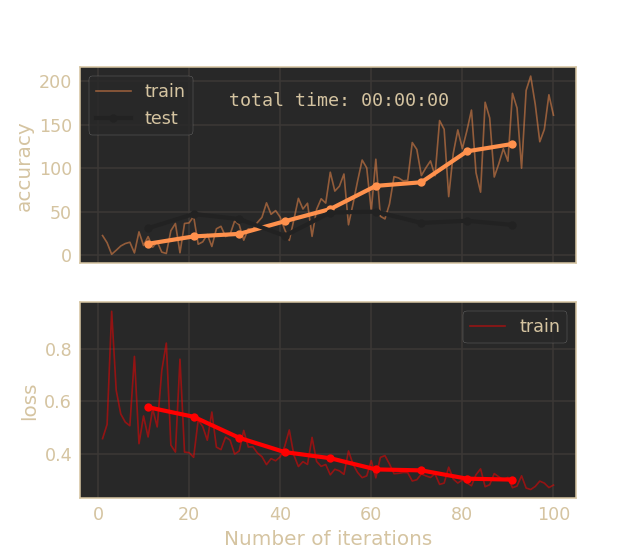

In [7]:
from liveplot import load_metrics, recreate_plot

train, test = load_metrics("tmp.npz")

colors = {"accuracy":dict(train="C4", test="C6"),
          "loss":"red"}

new_plotter, fig, ax = recreate_plot(train_metrics=train,
                                     test_metrics=test,
                                     colors=colors)


## Using liveplot to Generate Static Plots
`liveplot` can also accommodate the use case were a single static figure is generated without necessarily being rendered in a window. This is useful when you are performing a computation on a grid-computing resource.

Simply set the refresh-rate to -1, and this will turn off all default plot rendering.

In [ ]:
# List of metric-names
metrics = ["accuracy", "loss"]
plotter, fig, ax = create_plot(metrics, refresh=-1)

Proceed by setting the data in the same fashion as before. Keep all of the previous `set_train_batch`, `set_test_batch`, `plot_train_epoch`, and `plot_test_epoch` calls, so that the data is logged and the epoch statistics are still computed appropriately. No plot will be rendered.

In [ ]:
for i, x in enumerate(np.linspace(0, 10, 100)):
    # training
    x += np.random.rand(1)*5
    batch_metrics = {"accuracy": x**2, "loss": 1/x**.5}
    plotter.set_train_batch(batch_metrics, batch_size=1)
    
    # cue training epoch
    if i%10 == 0 and i > 0:
        plotter.plot_train_epoch()
        
        # cue test-time computations
        for x in np.linspace(0, 10, 5):
            x += (np.random.rand(1) - 0.5)*5
            test_metrics = {"accuracy": x**2}
            plotter.set_test_batch(test_metrics, batch_size=1)
        plotter.plot_test_epoch()

plotter.plot()  # ensures final data gets drawn to figure

Now you are free to save the plot using the `fig` object (returned above via `create_plot`). If you do want to show the final plot in a window, you can call:

In [ ]:
plotter.show()